In [39]:
# ========================
# 📌 1. Import Libraries
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import joblib

In [40]:
# ==========================
# 📌 2. Load and Preprocess Data
# ==========================
df_original = pd.read_csv('Battery_data_set_1.csv')
df = pd.read_csv('Battery_data_set_1.csv')

# Remove irrelevant columns
cols_to_remove = [
    'device_id', 'timestamp', 'foreground_app', 'collected',
    'wifi_status', 'wifi_intensity', 'wifi_speed', 'wifi_ap', 'wifi_rx', 'wifi_tx',
    'nfc', 'flashlight', 'airplane_mode', 'fingerprint', 'mobile_roaming',
    'mobile_mode', 'cpu_temperature', 'network_operator', 'sim_operator', 'mcc', 'mnc',
    'saving_mode' 
]
df.drop(columns=[col for col in cols_to_remove if col in df.columns], errors='ignore', inplace=True)


C:\Users\Vidhyarth\AppData\Local\Temp\ipykernel_26292\3808428635.py:4: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv('Battery_data_set_1.csv')
C:\Users\Vidhyarth\AppData\Local\Temp\ipykernel_26292\3808428635.py:5: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Battery_data_set_1.csv')


In [41]:
# ======================================
# 📌 3. Feature Engineering
# ======================================
df['discharge_rate'] = df['battery_current'].abs() / (df['battery_level'] + 1)
df['power_efficiency'] = df['battery_power'].abs() / (df['cpu_usage'] + 1)
df['ram_usage_ratio'] = df['ram_usage'] / (df['ram_usage'] + df['ram_free'])
df['rom_usage_ratio'] = df['rom_usage'] / (df['rom_usage'] + df['rom_free'])
df['battery_temp_current_ratio'] = df['battery_temperature'] / (df['battery_current'].abs() + 1)
df['screen_power_impact'] = df['screen_status'] * df['bright_level'] * df['battery_current'].abs() / 1000

# Combine all CPU core frequencies into a single mean frequency column
core_columns = [col for col in df.columns if 'frequency_core' in col]
if core_columns:
    df['avg_frequency'] = df[core_columns].mean(axis=1)
    df.drop(columns=core_columns, inplace=True)


In [42]:
# ======================================
# 📌 4. Handle Categorical Variables & Missing Values
# ======================================
df = pd.get_dummies(df, drop_first=True)  # One-hot encoding for categorical variables
df.fillna(df.median(), inplace=True)  # Fill missing values with median


In [43]:
# ======================================
# 📌 5. Remove Outliers Using IQR
# ======================================
def remove_outliers(df, threshold=3.0):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - threshold * IQR)) | (df > (Q3 + threshold * IQR))).any(axis=1)]

df_clean = remove_outliers(df, threshold=3.0)
joblib.dump(list(df_clean.columns), "feature_names.pkl")  

['feature_names.pkl']

In [44]:
# ======================================
# 📌 6. Feature Scaling (MinMax Scaler)
# ======================================
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_clean)
joblib.dump(scaler,"scaler.pkl")


['scaler.pkl']

In [45]:
# ======================================
# 📌 7. Apply PCA (Reduce to 2D)
# ======================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
joblib.dump(pca,"pca_model.pkl")


['pca_model.pkl']

In [46]:
# ======================================
# 📌 8. Apply K-Means Clustering (K=2)
# ======================================
model = KMeans(n_clusters=2, random_state=42, n_init=10)
model.fit(X_pca)

cluster_labels = model.fit_predict(X_pca)

joblib.dump(model,"trained_model.pkl")


['trained_model.pkl']

In [47]:
# ======================================
# 📌 9. Evaluate Clustering Performance
# ======================================
silhouette_avg = silhouette_score(X_pca, cluster_labels)
db_score = davies_bouldin_score(X_pca, cluster_labels)

print(f"✅ Silhouette Score: {silhouette_avg:.4f} (higher is better)")
print(f"✅ Davies-Bouldin Index: {db_score:.4f} (lower is better)")


✅ Silhouette Score: 0.7959 (higher is better)
✅ Davies-Bouldin Index: 0.3800 (lower is better)


In [48]:
# ======================================
# 📌 10. Save Cleaned Dataset
# ======================================
df_clean.to_csv("cleaned_battery_data.csv", index=False)
print("✅ Cleaned dataset saved as 'cleaned_battery_data.csv'.")


✅ Cleaned dataset saved as 'cleaned_battery_data.csv'.


In [49]:
# ======================================
# 📌 11. Save Reduced Dataset (With PCA)
# ======================================
df_reduced = df_clean.copy()
df_reduced['PC1'] = X_pca[:, 0]
df_reduced['PC2'] = X_pca[:, 1]
df_reduced = df_reduced[['PC1', 'PC2']]

df_reduced.to_csv("reduced_battery_data.csv", index=False)
print("✅ Reduced dataset saved as 'reduced_battery_data.csv'.")


✅ Reduced dataset saved as 'reduced_battery_data.csv'.


In [50]:
# ======================================
# 📌 12. Display Features Before & After
# ======================================
print("✅ Original Features Before Processing:")
print(list(df_original.columns))

print("\n✅ Features After Cleaning & Engineering:")
print(list(df_clean.columns))

print("\n✅ PCA Reduced Features:")
print(list(df_reduced.columns))


✅ Original Features Before Processing:
['device_id', 'timestamp', 'screen_status', 'bright_level', 'bright_mode', 'screen_on_time', 'bluetooth', 'gps_status', 'gps_activity', 'saving_mode', 'nfc', 'flashlight', 'airplane_mode', 'fingerprint', 'orientation', 'battery_level', 'battery_health', 'battery_charging_status', 'battery_connection_status', 'battery_temperature', 'battery_current', 'battery_voltage', 'battery_power', 'network_mode', 'mobile_mode', 'mobile_status', 'mobile_roaming', 'mobile_rx', 'mobile_tx', 'wifi_status', 'wifi_intensity', 'wifi_speed', 'wifi_ap', 'wifi_rx', 'wifi_tx', 'network_operator', 'sim_operator', 'mcc', 'mnc', 'ring_mode', 'sound_level', 'playback_status', 'ram_usage', 'ram_free', 'rom_usage', 'rom_free', 'cpu_usage', 'cpu_temperature', 'up_time', 'sleep_time', 'frequency_core0', 'frequency_core1', 'frequency_core2', 'frequency_core3', 'frequency_core4', 'frequency_core5', 'frequency_core6', 'frequency_core7', 'foreground_app', 'collected']

✅ Features Af

PLOTS

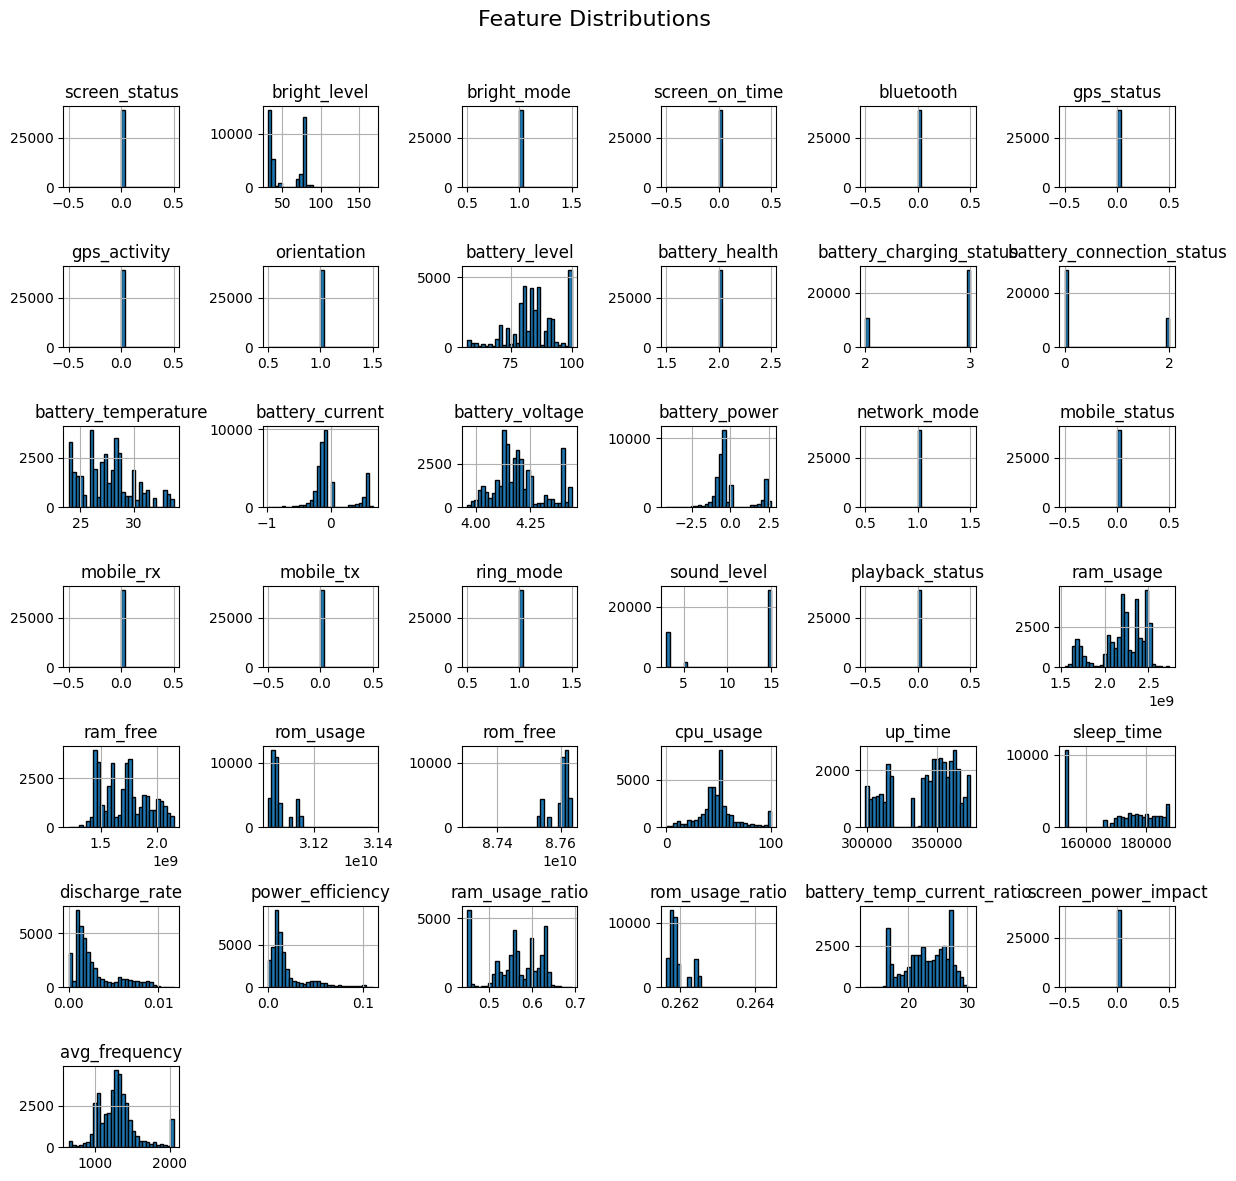

In [51]:
# ======================================
# 📌 1. Feature Selection (Understanding Data)
# ======================================

import matplotlib.pyplot as plt

# Create histograms for all features
df_clean.hist(bins=30, figsize=(12, 12), edgecolor="black")

# Adjust spacing to prevent overlap
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


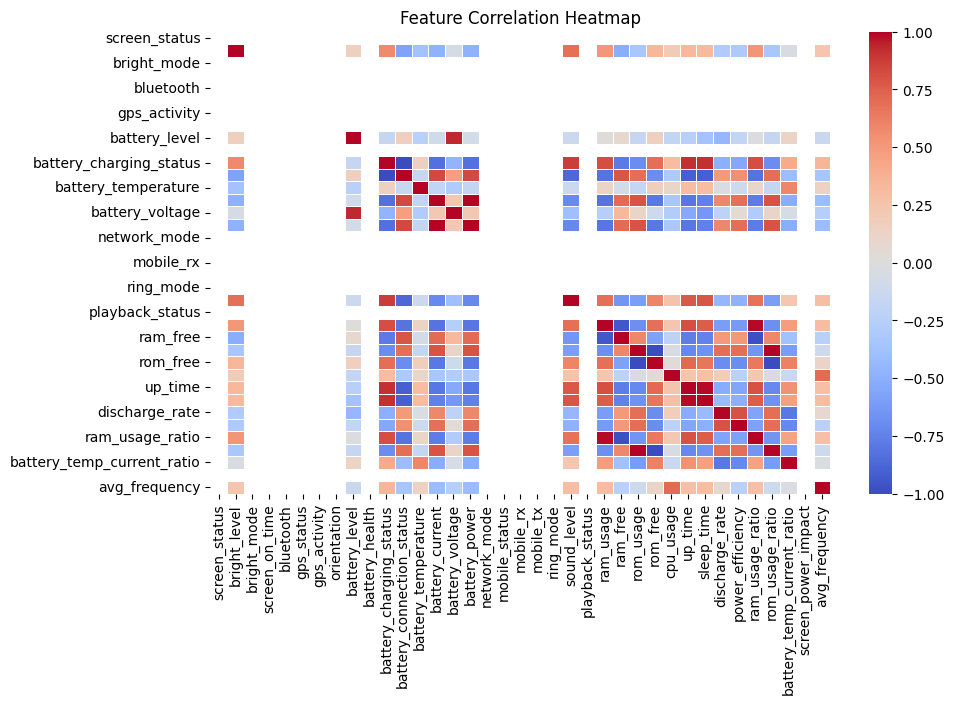

In [52]:
# ======================================
# 📌 2. Feature Correlation Heatmap
# ======================================

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


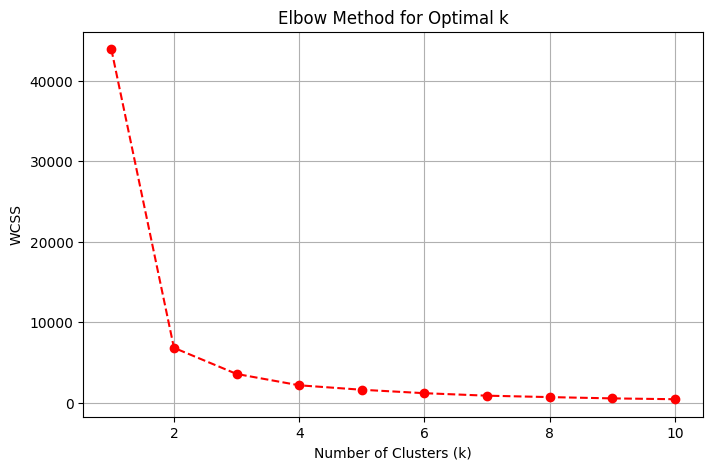

In [53]:
# ======================================
# 📌 3. Elbow Method for Optimal K
# ======================================

from sklearn.cluster import KMeans

wcss = []
k_values = range(1, 11)  # Testing k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(k_values, wcss, marker='o', linestyle='--', color='r')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()


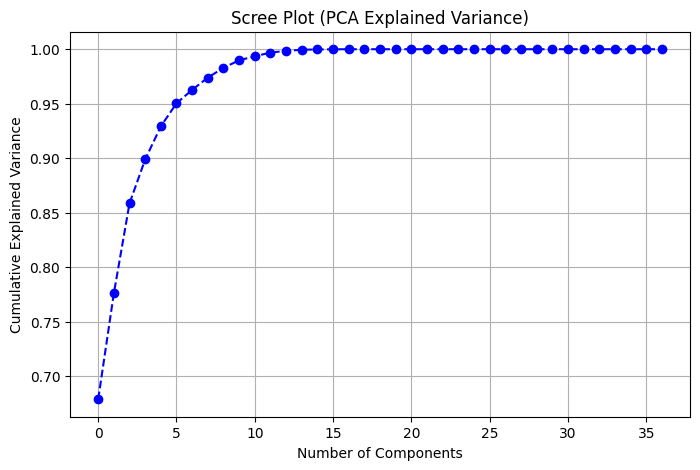

In [54]:
# ======================================
# 📌 4. Scree Plot (PCA Explained Variance)
# ======================================

import numpy as np
from sklearn.decomposition import PCA

# Fit PCA on the scaled data
pca = PCA().fit(X_scaled)

# Plot Explained Variance Ratio
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot (PCA Explained Variance)')
plt.grid()
plt.show()


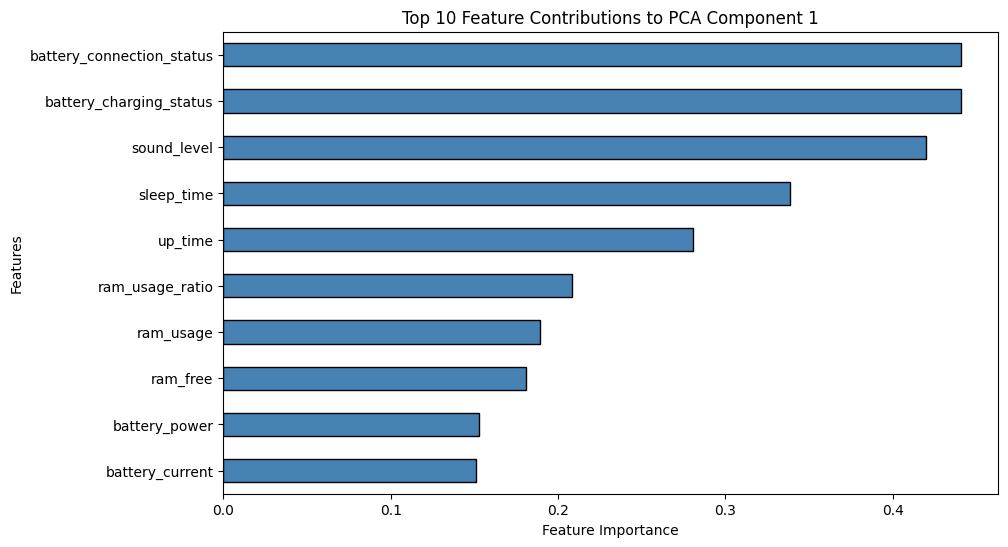

In [55]:
# ======================================
# 📌 5. Top 10 Feature Contributions to PCA
# ======================================

# Get the number of features used in PCA
num_pca_features = pca.components_.shape[1]

# Extract the feature names used in PCA
pca_feature_names = df_clean.columns[:num_pca_features]

# Extract feature importance from PCA components
pca_importance = pd.Series(abs(pca.components_[0]), index=pca_feature_names)

# Select the top 10 most influential features
top_10_features = pca_importance.nlargest(10)

# Plot the feature importance
plt.figure(figsize=(10, 6))
top_10_features.plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Contributions to PCA Component 1")
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.show()


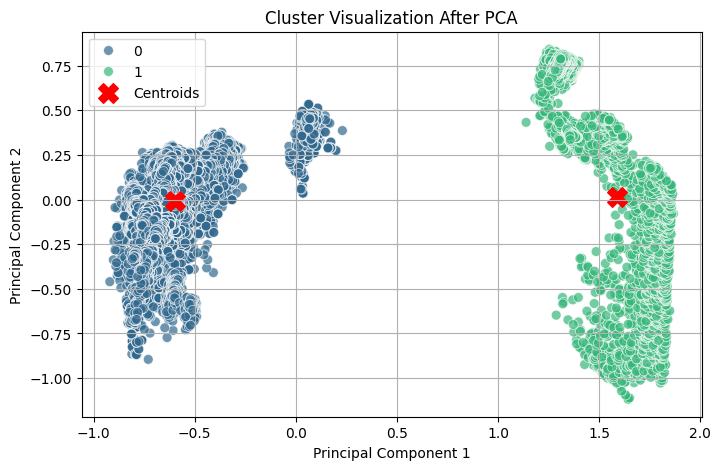

In [56]:
# ======================================
# 📌 6. Cluster Visualization After PCA
# ======================================

import seaborn as sns

# Get cluster labels
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# Scatter plot of clusters
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', s=50, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization After PCA')
plt.legend()
plt.grid()
plt.show()
